<a href="https://colab.research.google.com/github/litlig/notebooks/blob/main/build_makemore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2026-01-07 20:43:05--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2026-01-07 20:43:05 (12.7 MB/s) - ‘names.txt’ saved [228145/228145]



In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
hidden_layer_size = 200
encoding_size = 15

In [9]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, encoding_size), generator=g)
W1 = torch.randn((encoding_size*4, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [10]:
sum(p.nelement() for p in parameters) # number of parameters in total

18032

In [11]:
for p in parameters:
  p.requires_grad = True

In [12]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [13]:
lri = []
lossi = []
stepi = []

In [14]:
mini_batch = 64
dict_size = 27

In [38]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, encoding_size), generator=g)
W1 = torch.randn((encoding_size*4, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size,1), generator = g)
b2 = torch.randn(dict_size, generator = g)
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True



12832


In [39]:
stepi = []
lossi = []
for i in range(200000):
  ix = torch.randint(0, Xtr.shape[0], (mini_batch,))
  xtr_expand = Xtr[ix].unsqueeze(1).expand(-1, dict_size, -1)
  vals = torch.arange(dict_size).view(1, dict_size, 1).expand(xtr_expand.size(0), dict_size, 1)
  result = torch.cat([xtr_expand, vals], dim=-1)

  emb = C[result]
  h = torch.tanh(emb.view(mini_batch, dict_size, encoding_size*4) @ W1 + b1)
  energy = (h @ W2).squeeze(-1) + b2
  loss = F.cross_entropy(-energy, Ytr[ix])

  for p in parameters:
    p.grad = None
  loss.backward()
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  if i % 10000 == 0:
    print(f'{i:7d}/{200000:7d}: {loss.item():.4f}')
  stepi.append(i)
  lossi.append(loss.log10().item())

      0/ 200000: 17.4034
  10000/ 200000: 2.3315
  20000/ 200000: 2.0628
  30000/ 200000: 2.2054
  40000/ 200000: 2.2147
  50000/ 200000: 2.2822
  60000/ 200000: 2.1065
  70000/ 200000: 2.1691
  80000/ 200000: 2.1578
  90000/ 200000: 1.9968
 100000/ 200000: 2.4052
 110000/ 200000: 2.0853
 120000/ 200000: 1.8461
 130000/ 200000: 2.2035
 140000/ 200000: 2.0507
 150000/ 200000: 2.5058
 160000/ 200000: 2.4372
 170000/ 200000: 2.1814
 180000/ 200000: 1.8689
 190000/ 200000: 2.1844


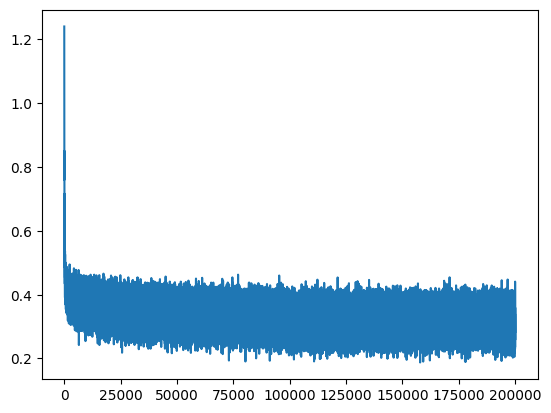

In [63]:
plt.plot(stepi, lossi)

In [62]:
ctx_size = 3

for _ in range(10):
  output = []
  context = [0] * ctx_size
  while True:
    ctx_expand = torch.tensor([context]).expand(dict_size, -1)
    vals = torch.arange(dict_size).view(dict_size,1).expand(ctx_expand.size(0), 1)
    result = torch.cat([ctx_expand, vals], dim = 1)
    emb = C[result]
    h = torch.tanh(emb.view(dict_size, encoding_size*4) @ W1 + b1)
    energy = (h @ W2).squeeze(-1) + b2
    probs = F.softmax(-energy, dim=0)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    output.append(ix)
    if ix == 0:
      print(''.join(itos[i] for i in output))
      break

col.
enny.
avamrisani.
saivromieralbrishna.
hebrin.
harmonna.
cani.
jervi.
adrie.
mace.


In [55]:
a = torch.tensor([[[1, 2, 3], [4, 5, 6]]])
b = torch.tensor([[8, 9, 10]])
torch.concat([a, b])

tensor([[ 1,  2,  3],
        [ 4,  5,  6],
        [ 8,  9, 10]])

In [16]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (mini_batch,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, encoding_size*3) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x45 and 60x200)

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, encoding_size*3) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

In [ ]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, encoding_size*3) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

In [ ]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, encoding_size*3) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))